# Вспомогательный код

**Для выполнения задания рекомендуется использовать среду с аппаратным ускорителем GPU.**

In [20]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Блок кода для визуализации процесса обучения модели:

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import clear_output


class ProgressPlotter:
    def __init__(self) -> None:
        self._history_dict = defaultdict(list)

    def add_scalar(self, tag: str, value) -> None:
        self._history_dict[tag].append(value)

    def display_keys(self, ax, tags):
        if isinstance(tags, str):
            tags = [tags]
        history_len = 0
        ax.grid()
        for key in tags:
            ax.plot(self._history_dict[key], marker="X", label=key)
            history_len = max(history_len, len(self.history_dict[key]))
        if len(tags) > 1:
            ax.legend(loc="lower left")
        else:
            ax.set_ylabel(key)
        ax.set_xlabel("epoch")
        ax.set_xticks(np.arange(history_len))
        ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
        clear_output()
        n_groups = len(groups)
        fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3 * n_groups))
        if n_groups == 1:
            ax = [ax]
        for i, keys in enumerate(groups):
            self.display_keys(ax[i], keys)
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

Чтобы результаты экспериментов воспроизводились, зафиксируем seed's

In [22]:
import random


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

# Задание 1. Создание полносвязной сети

1. Создайте двух-трех-слойную* полносвязную нейронную сеть средствами PyTorch.
2. Дополните недостающий код для обучения.
3. Обучите нейросеть на CIFAR-10.
4. Посмотрите график зависимости loss и accuracy от эпохи в процессе обучения.

Для создания полносвязных слоев используйте класс [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear).

*Рекомендуется использовать скрытый слой со 128 нейронами.

Установка и импорт необходимых библиотек:

In [4]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.2 MB/s eta 0:00:00


In [5]:
import torchvision
import torchmetrics
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split

Загрузим датасет с помощью средств PyTorch.

In [6]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = CIFAR10(root="./CIFAR10", train=True, download=True, transform=transform)
testset = CIFAR10(root="./CIFAR10", train=False, download=True, transform=transform)

trainset, valset, _ = random_split(dataset, lengths=[12000, 3000, 35000])

100%|██████████| 170498071/170498071 [00:02<00:00, 68064077.29it/s] 


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


Обратите внимание, что для ускорения процесса отладки мы используем только часть обучающих данных. В обучающей выборке CIFAR-10 содержится 50&nbsp;000 изображений. При помощи функции [`random_split`](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) из модуля `torch.utils.data` мы взяли 15&nbsp;000 изображений: 12&nbsp;000 для обучения и 3000 для валидации. Остальные 35&nbsp;000 изображений мы не используем: передаем их в объект с именем&nbsp;`_`. Так стоит поступать в будущем при отладке вашей нейронной сети. Однако после завершения отладки для финального обучения следует использовать все доступные данные, тогда обобщающая способность и качество нейронной сети будут лучше.

Также обратите внимание, что сумма значений в параметре `lengths` функции `random_split` должна в точности равняться количеству элементов в датасете, который она разделяет. Поэтому, код

`trainset, valset  = random_split(dataset, lengths=[12000, 3000])`

выдаст ошибку, так как количество элементов в `dataset` равно 50&nbsp;000, а сумма элементов во втором аргументе функции равна 15&nbsp;000.

Опишите структуру сети: полносвязные слои + [функции активации](https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity) на ваш выбор.

In [19]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(3 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers_stack(x)
        return logits

**Блок обучения.**

Обратите внимание на то, что в PyTorch моделях не используется метод fit, как в sklearn. Код, отвечающий за обучение, пишется отдельно.

Определим `batch_size` и создадим два DataLoader-а для обучающей и валидационной выборок

In [8]:
batch_size = 256

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

Функцию для подсчёта точности возьмем из библиотеки [`torchmetrics`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html):

In [49]:
score_function = torchmetrics.Accuracy(task="multiclass", num_classes=10)

**Цикл обучения и валидации.**

Определим функции `train_loop` и `val_loop`. Допишите недостающий код. Пользуйтесь материалом лекции.


In [17]:
def train_loop(dataloader, model, criterion, optimizer, score_function, device):
    num_batches = len(dataloader)

    train_loss = 0
    y_true, y_pred = torch.Tensor(), torch.Tensor()

    for imgs, labels in dataloader:
        # Compute prediction and loss
        pred =  model(imgs.to(device))
        loss =  criterion(pred, labels.to(device))

        # Optimization
        # Nullify gradients, do a backward and do an optimization step
        # Your code here
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # End of your code

        train_loss += loss.item()

        # accumulating true labels to calculate score function
        y_true = torch.cat([y_true, labels], dim=0)

        # getting predicted labels from logits by argmax
        pred_labels = pred.detach().cpu().argmax(dim=1)
        # accumulating predicted labels to calculate score function
        y_pred = torch.cat([y_pred, pred_labels], dim=0)

    train_loss /= num_batches
    train_score = score_function(y_pred, y_true)

    return train_loss, train_score

In [18]:
def val_loop(dataloader, model, criterion, score_function, device):
    num_batches = len(dataloader)

    val_loss = 0
    y_true, y_pred = torch.Tensor(), torch.Tensor()

    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred = model(imgs.to(device))
            loss = criterion(pred, labels.to(device))

            val_loss += loss.item()

            # accumulating true labels to calculate score function
            y_true = torch.cat([y_true, labels], dim=0)

            # getting predicted labels from logits by argmax
            pred_labels = pred.detach().cpu().argmax(dim=1)
            # accumulating predicted labels to calculate score function
            y_pred = torch.cat([y_pred, pred_labels], dim=0)

    val_loss /= num_batches
    val_score = score_function(y_pred, y_true)

    return val_loss, val_score

Дополните функцию `train` вызовом `train_loop` и `val_loop` внутри цикла по эпохам

In [19]:
def train(model,
          train_loader,
          val_loader,
          criterion,
          optimizer,
          score_function,
          device,
          num_epochs=10):

    pp = ProgressPlotter()
    for i in range(num_epochs):

        # properly call train_loop and val_loop
        train_loss, train_score =  train_loop(train_loader, model, criterion, optimizer, score_function, device)


        val_loss, val_score = val_loop(val_loader, model, criterion, score_function, device)

        # logging
        pp.add_scalar("loss_train", train_loss)
        pp.add_scalar("score_train", train_score)

        pp.add_scalar("loss_val", val_loss)
        pp.add_scalar("score_val", val_score)

        pp.display([["loss_train", "loss_val"], ["score_train", "score_val"]])
    return pp

Создание экземпляра модели, определение оптимизатора, функции потерь, и собственно запуск обучения.

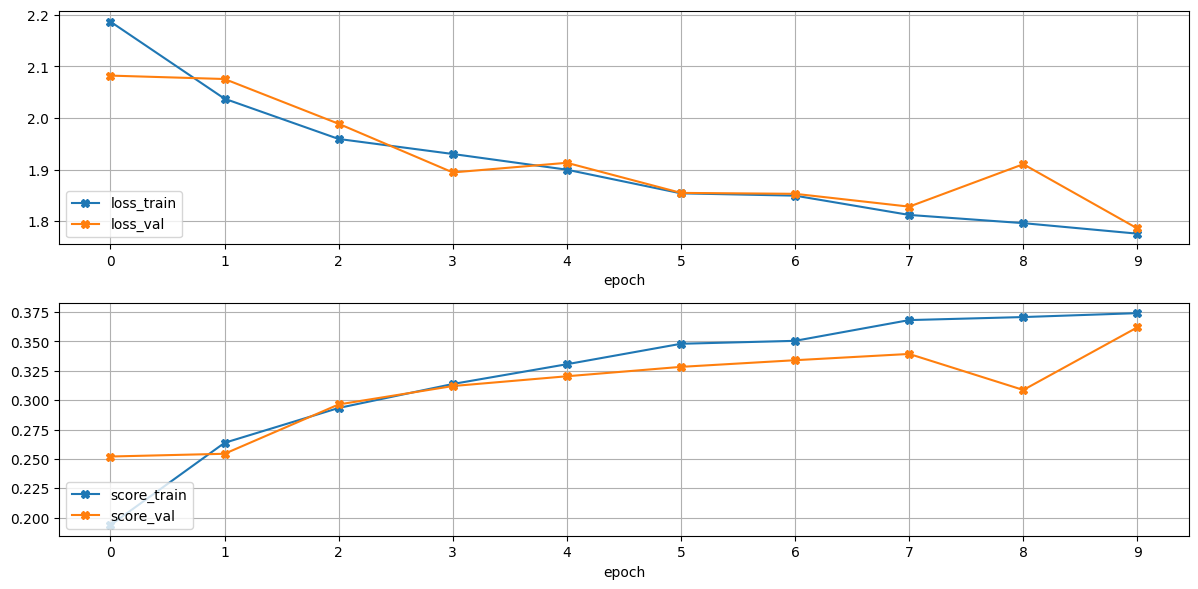

In [20]:
model = FCNet().to(device)  # Create model instance and move it to device

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # Weights update algorithm
criterion = nn.CrossEntropyLoss()  # Loss function

pp = train(model, train_loader, val_loader, criterion, optimizer, score_function, device, num_epochs=10)

Функция `train` возвращает объект `ProgressPlotter`, который имеет атрибут `.history_dict` — словарь, в котором хранится история обучения модели: значение функции потерь и точности на обучающих и валидационных данных по эпохам.

По ключу `score_val` можно извлечь из словаря значения точности на валидационных данных по эпохам и вывести итоговую точность модели, достигнутую на последней (`-1`-й) эпохе.

In [21]:
accuracy = pp.history_dict["score_val"][-1]
print(f"Accuracy {accuracy:.2f}")

Accuracy 0.36


## Формат результата

График обучения сети.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX05/result_1_task_ex05.png" width="800">

# Задание 2. Нормализация данных

Стандартизируйте данные.

* Подсчитайте среднее значение и стандартное отклонение для каждого из 3-х цветовых каналов
 * Сделайте это с помощью встроенных в PyTorch или NumPy функций
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`[🛠️[doc]](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html))
* Оцените влияние нормировки данных на точность обучения (сравните результаты обучения на сырых данных в задании №1 и на стандартизованных).

Посмотрим на размерность тензора с обучающими данными

In [22]:
print(dataset.data.shape)

(50000, 32, 32, 3)


Вычислите средние и стандартные отклонения **по каждому из трех цветовых каналов** для обучающих данных.

Каждый канал изображения стандартизуется независимо. Поэтому каждый из объектов `cifar10_mean` и `cifar10_std` должен представлять из себя последовательность (`list` / `np.ndarray` / `torch.Tensor`) длиной в количество каналов.

Также не забудьте, что `Normalize` будет применяться после `ToTensor` и поэтому средние и стандартные отклонения должны быть отмасштабированы в $[0,1]$.

In [31]:
dataset.data[trainset.indices].shape

(12000, 32, 32, 3)

In [42]:
cifar10_mean = np.mean(dataset.data[trainset.indices], axis=(0, 1, 2))
cifar10_std = np.std(dataset.data[trainset.indices], axis=(0, 1, 2))
print(f"Mean: {cifar10_mean}, Std: {cifar10_std}")

Mean: [125.59041309 123.16670312 114.09996126], Std: [62.8748509  61.87579565 66.59067644]


In [44]:
cifar10_max = np.max(dataset.data[trainset.indices], axis=(0, 1, 2))
cifar10_max

array([255, 255, 255], dtype=uint8)

In [45]:
cifar10_mean = cifar10_mean / cifar10_max
cifar10_std = cifar10_std / cifar10_max
print(f"Mean: {cifar10_mean}, Std: {cifar10_std}")

Mean: [0.49251142 0.48300668 0.44745083], Std: [0.24656804 0.24265018 0.26113991]


Создайте трансформацию, которая включает в себя нормализацию, и подмените трансформацию в обучающем и тестовом Dataset-ах на новую.

**Внимание! Неочевидная особенность!**

Атрибут `.transform` необходимо переопределить не у объектов `trainset` и `valset`, а у объекта `dataset`, из которого `trainset` и `valset` были случайно отобраны с помощью функции `random_split` в задании №1.

Функция `random_split` возвращает объекты класса `Subset`, которые не имеют своих трансформаций, а используют трансформации, определенные родительском в `Dataset`-е.

In [46]:
from torchvision import transforms

transform_with_normalize = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(cifar10_mean, cifar10_std)]
)

# Your code here
dataset.transform = transform_with_normalize

Снова создайте экземпляр модели, определите оптимизатор и функцию потерь, и вызовите функцию для обучения (можно скопировать код из задания 1).

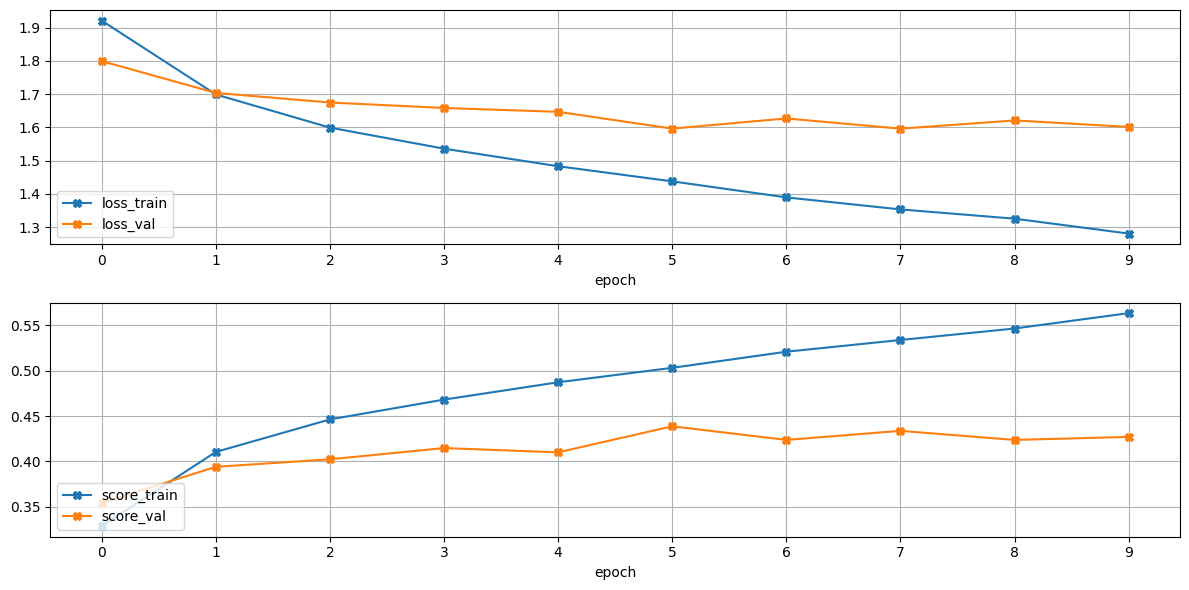

In [47]:
# Your code here
model = FCNet().to(device)  # Create model instance and move it to device

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # Weights update algorithm
criterion = nn.CrossEntropyLoss()  # Loss function

pp = train(model, train_loader, val_loader, criterion, optimizer, score_function, device, num_epochs=10)

Выведите итоговую точность на валидационных данных.

In [48]:
# Your code here
accuracy = pp.history_dict["score_val"][-1]
print(f"Accuracy {accuracy:.2f}")

Accuracy 0.43


## Формат результата

График обучения сети.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX05/result_2_task_ex05.png" width="800">

# Задание 3. Повышение точности классификатора

Классифицируйте CIFAR-10 с максимальной точностью.

Для этого:

*  Используйте весь датасет для обучения
*  Примените нормализацию к данным
*  Подберите шаг обучения
*  Обучайте сеть порядка 25 эпох
*  При необходимости можете добавить в модель еще один скрытый слой


In [51]:
testset.data.shape

(10000, 32, 32, 3)

In [52]:
# new split using all train data
trainset, valset = random_split(dataset, lengths=[40000, 10000])
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)


# normalize
cifar10_max = np.max(dataset.data[trainset.indices], axis=(0, 1, 2))
cifar10_mean = np.mean(dataset.data[trainset.indices], axis=(0, 1, 2)) / cifar10_max
cifar10_std = np.std(dataset.data[trainset.indices], axis=(0, 1, 2)) / cifar10_max

transform_with_normalize = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(cifar10_mean, cifar10_std)]
)
dataset.transform = transform_with_normalize

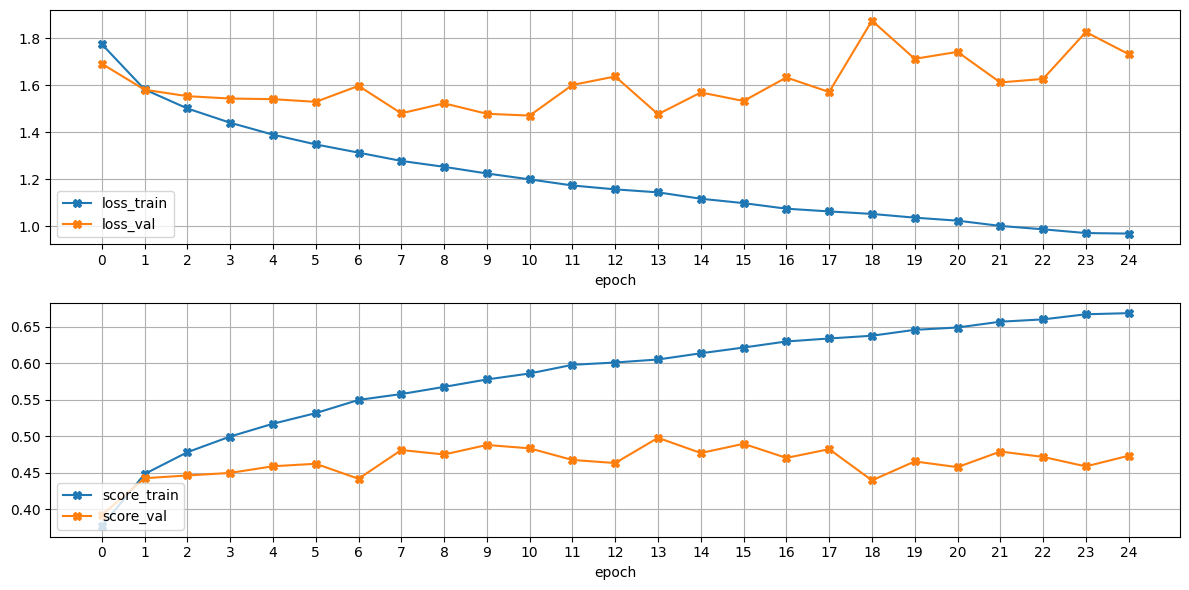

In [53]:

model = FCNet().to(device)  # Create model instance and move it to device

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)  # Weights update algorithm
criterion = nn.CrossEntropyLoss()  # Loss function

pp = train(model, train_loader, val_loader, criterion, optimizer, score_function, device, num_epochs=25)

Оцените точность на **тестовом** датасете (`testset`).

Для этого **создайте DataLoader для тестовых данных**. Для оценки точности можно воспользоваться функцией `val_loop`.



In [55]:
# Your code here
testset.transform = transform_with_normalize
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
val_loss, val_score = val_loop(test_loader, model, criterion, score_function, device)
print(f"Accuracy {val_score:.2f}")

Accuracy 0.48


## Формат результата

Выведите графики как в первом задании. Вы должны получить точность 0.48 .. 0.52

# Задание 4. Техники для работы в условиях дисбаланса классов

В этом задании вам предлагается решить задачу классификации на несбалансированном датасете [Car Evaluation](https://archive.ics.uci.edu/dataset/19/car+evaluation).

Требуется обучить полносвязную нейронную сеть, сделав бейзлайн с функцией потерь `CrossEntropyLoss`, а затем реализовать различные техники для работы в условиях дисбаланса:

1. `CrossEntropyLoss` **с весами для классов**,
2. `FocalLoss`,
3. `FocalLoss` **с весами для классов**,
4. `WeightedRandomSamlper` при функции потерь `CrossEntropyLoss`,
5. `WeightedRandomSamlper` при функции потерь `FocalLoss`,

сравнить их между собой и сделать выводы.

Установка и импорт необходимых библиотек:

In [1]:
!pip install -q torchmetrics

In [7]:
import torch
import torchmetrics
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Обзор датасета и подготовка данных для обучния

Загрузим датасет и взглянем на него:

In [3]:
# !wget -qN https://archive.ics.uci.edu/static/public/19/car+evaluation.zip
!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/car_evaluation.zip
!unzip -qo car_evaluation.zip

In [4]:
data = pd.read_csv(
    "car.data",
    names=["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"],
)

data

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


В архиве найдем текстовый файл с описанием датасета `car.names`. Выведем его:

In [5]:
!cat car.names

1. Title: Car Evaluation Database

2. Sources:
   (a) Creator: Marko Bohanec
   (b) Donors: Marko Bohanec   (marko.bohanec@ijs.si)
               Blaz Zupan      (blaz.zupan@ijs.si)
   (c) Date: June, 1997

3. Past Usage:

   The hierarchical decision model, from which this dataset is
   derived, was first presented in 

   M. Bohanec and V. Rajkovic: Knowledge acquisition and explanation for
   multi-attribute decision making. In 8th Intl Workshop on Expert
   Systems and their Applications, Avignon, France. pages 59-78, 1988.

   Within machine-learning, this dataset was used for the evaluation
   of HINT (Hierarchy INduction Tool), which was proved to be able to
   completely reconstruct the original hierarchical model. This,
   together with a comparison with C4.5, is presented in

   B. Zupan, M. Bohanec, I. Bratko, J. Demsar: Machine learning by
   function decomposition. ICML-97, Nashville, TN. 1997 (to appear)

4. Relevant Information Paragraph:

   Car Evaluation Database was 

В датасете содержится 1728 наблюдений об автомобилях, которые описываются шестью категориальными признаками:
1. `buying` — стоимость покупки
2. `maint` — стоимость обслуживания
3. `doors` — количество дверей
4. `persons` — количество пассажиров
5. `lug_boot` — размер багажника
6. `safety` — оценка безопасности машины.

Также имеется целевой признак `class` с четырьмя уникальными значениями:

* `unacc` — неприемлемо
* `acc` — приемлемо
* `good` — хорошо
* `vgood` — отлично

Оценим баланс классов:

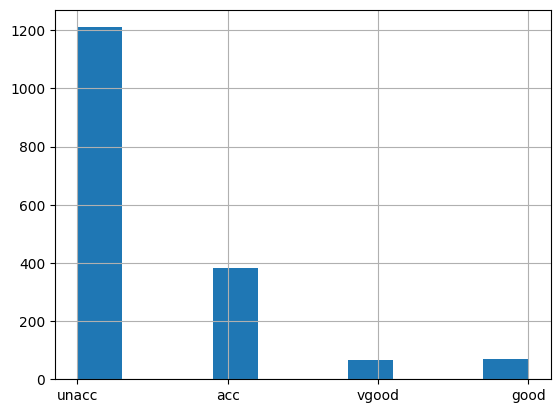

In [8]:
data["class"].hist()
plt.show()

Посмотрим на описательные статистики по признакам:

In [9]:
data.describe()

,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


Все входные признаки в датасете — категориальные, поэтому предварительно нужно их закодировать. Воспользуемся [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)-ом для кодирования входных признаков.

In [10]:
# split data to input x and target y
x, y = data.iloc[:, :-1], data.iloc[:, -1]

In [11]:
encoder = OneHotEncoder(sparse_output=False)

x_encoded = encoder.fit_transform(x)

x_encoded.shape

(1728, 21)

Классы просто закодируем порядковыми числами:

In [12]:
classes = ["unacc", "acc", "good", "vgood"]
class_labels = [0, 1, 2, 3]
class_to_idx = dict(zip(classes, class_labels))
class_to_idx

{'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}

In [13]:
y_encoded = y.map(class_to_idx)  # mapping class names into their indexes
y_encoded = y_encoded.values  # transform Pandas Series into numpy array
y_encoded

array([0, 0, 0, ..., 0, 2, 3])

Разделим данные на обучающие и тестовые в соотношении 80/20 и переведем их в `torch.tensor`:

In [14]:
x_train, x_test, y_train, y_test = train_test_split(
    x_encoded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

Создадим `Dataset`-ы и `DataLoader`-ы для обучения нейросетей.

Обучающие и тестовые данные представляют из себя уже предобработанные тензоры. Поэтому для создания `Dataset`-ов можно воспользоваться классом [`TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset).

In [15]:
trainset = torch.utils.data.TensorDataset(x_train, y_train)

testset = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Напишите архитектуру полносвязной сети для этого датасета. Рекомендуется использовать 1–2 скрытых слоя из 5–10 нейронов.

In [24]:
x_train.shape

torch.Size([1382, 21])

In [26]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Linear(21, 10),
            nn.ReLU(),
            nn.Linear(10, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )

    def forward(self, x):
        logits = self.layers_stack(x)
        return logits

## Показатель качества при дисбалансе

Так как набор данных несбалансирован, оценивать качество модели по accuracy будет некорректно. В качетсве фукнции оценки можем выбрать F1-score. Его реализацию для удобства возьмем из [`torchmetrics`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f-1-score):

In [16]:
score_function = torchmetrics.F1Score(task="multiclass", num_classes=4, average="macro")

## Бейзлайн c кросс-энтропией

Далее будет серия экспериментов по обучению нейросети на этом датасете с применением различных техник работы в условиях дисбаланса классов.
Для начала обучите бейзлайн с `CrossEntropyLoss`.

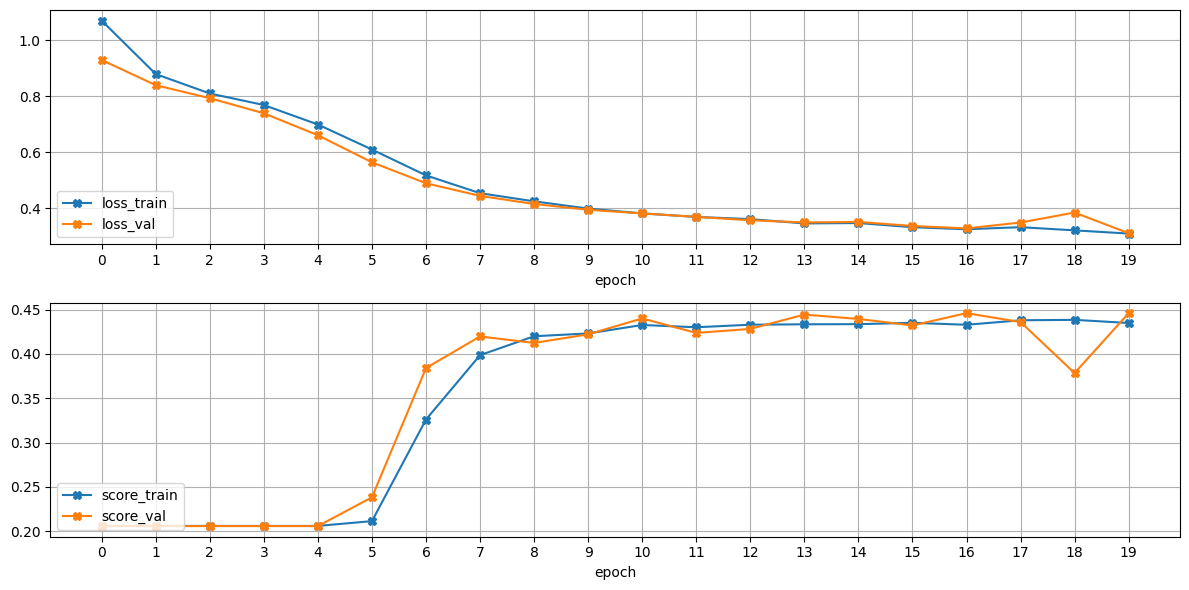

In [35]:
set_random_seed(42)

model = Network().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Напишем функцию для прогона DataLoader-a через модель и получения предсказаний.

In [28]:
def get_true_and_pred(dataloader, model):
    y_true, y_pred = [], []

    for input, target in dataloader:
        y_true.append(target)
        output = model(input.to(device))
        output = torch.argmax(output.cpu().detach(), dim=1)
        y_pred.append(output)

    y_true = np.array(torch.cat(y_true))
    y_pred = np.array(torch.cat(y_pred))

    return y_true, y_pred

Выведем отчет о качестве классификации тестовой выборки с помощью [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html):

In [36]:
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

              precision    recall  f1-score   support

       unacc       0.98      0.98      0.98       242
         acc       0.70      0.95      0.80        77
        good       0.00      0.00      0.00        14
       vgood       0.00      0.00      0.00        13

    accuracy                           0.90       346
   macro avg       0.42      0.48      0.45       346
weighted avg       0.84      0.90      0.86       346



Также посмотрим на матрицу ошибок ([`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Отобразим ее с помощью [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html).

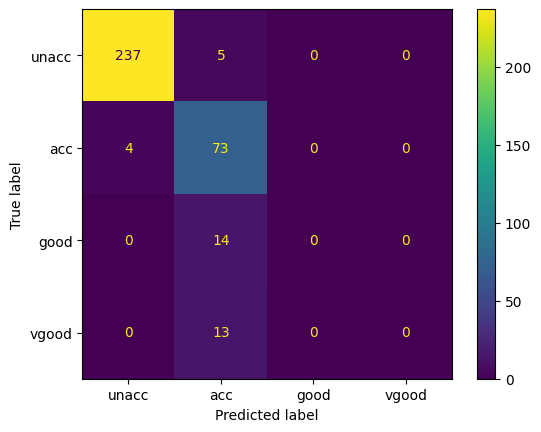

In [37]:
cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Опишите результаты классификации. Какие проблемы вы наблюдаете?

Видно, что 2 самых частых класса предсказываются в основном правильно, а вот 2 minor класса вообще никогда не предсказываются, что нам естественно не нравится.

## Кросс-энтропия с весами для классов

Вам нужно создать одномерный тензор `weights_for_classes` с весами для классов. В качестве весов можно взять величины, обратные к количеству объектов определенного класса в обучающей выборке.

**Обратите внимание**, тензор с весами `weights_for_classes` должен быть перенесен на `device`.

In [31]:
# Your code here
_, classes_counts = torch.unique(y_train, return_counts=True)  # y — tensor of labels in train set
weights_for_classes = (classes_counts.max() / classes_counts).to(device)
weights_for_classes

tensor([ 1.0000,  3.1531, 17.6000, 18.6154], device='cuda:0')

Обучите модель с `CrossEntropyLoss`, передав ей в качестве аргумента `weight` тензор `weights_for_classes`.

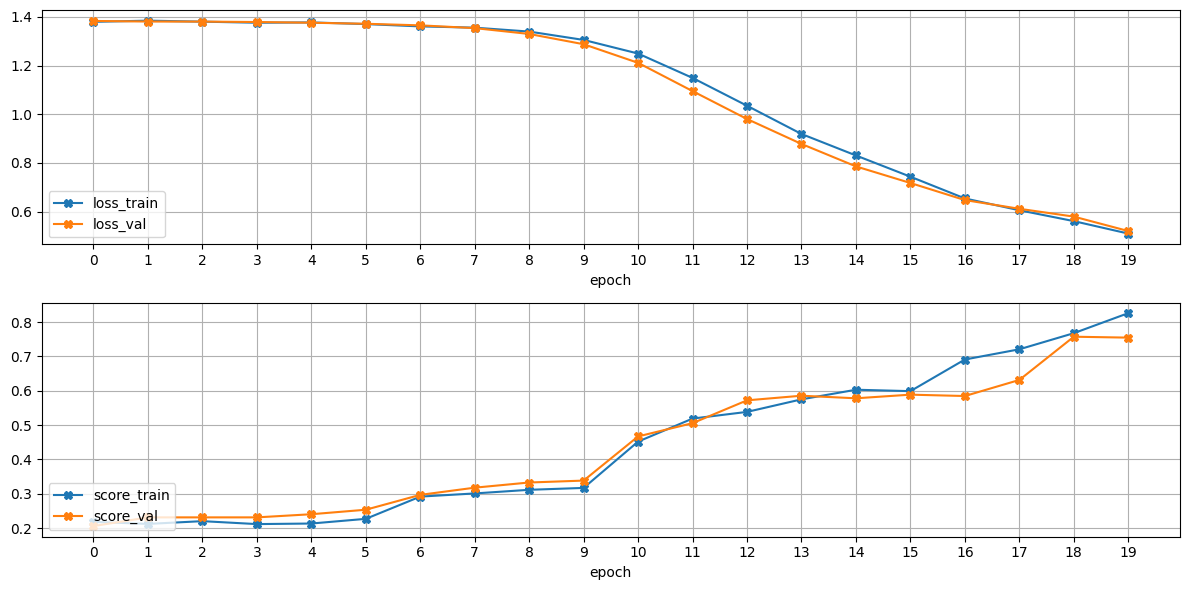

In [38]:
set_random_seed(42)

model = Network().to(device)

criterion =  nn.CrossEntropyLoss(weight=weights_for_classes)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество обработки тестовой выборки с помощью отчета о классификации и матрицы ошибок.

In [39]:
# Your code here
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

              precision    recall  f1-score   support

       unacc       1.00      0.83      0.90       242
         acc       0.61      0.92      0.74        77
        good       0.88      0.50      0.64        14
       vgood       0.59      1.00      0.74        13

    accuracy                           0.84       346
   macro avg       0.77      0.81      0.75       346
weighted avg       0.89      0.84      0.85       346



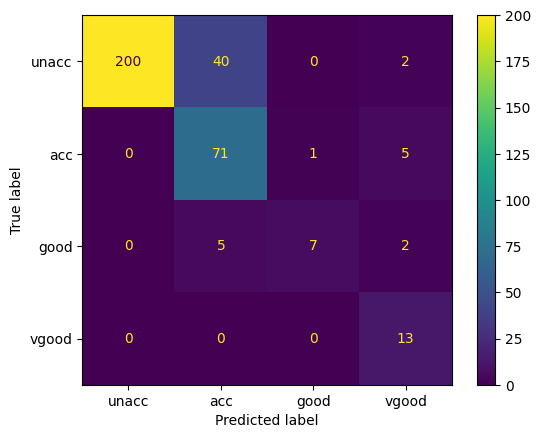

In [40]:
cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Опишите, как изменилось качество классификации.

Теперь видим, что f1 score увеличился аж на 0.3 по сравнению с бейзлайном, и теперь minor классы уже предсказываются моделью, причем минимальный класс полностью правильно предсказывается. Также можно видеть, что самый большой класс стал предсказываться хуже (из-за наименьшего веса в функции потерь).

## Focal Loss

Воспользуйтесь Focal Loss в качестве функции потерь подобно тому, как вы сделали в бейзлайне с кросс-энтропией.

В этом пункте **не используйте** веса для классов. Параметр $\gamma$ примите равным $2$.

In [41]:
#!wget -qN https://raw.githubusercontent.com/AdeelH/pytorch-multi-class-focal-loss/master/focal_loss.py
!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX05/focal_loss.py

Информация из [документации](https://github.com/AdeelH/pytorch-multi-class-focal-loss/blob/master/focal_loss.py):

* `alpha` (*Tensor*, optional): Weights for each class. Defaults to `None`.
* `gamma` (*float*, optional): A constant, as described in the paper. Defaults to `0`.
* `reduction` (*str*, optional): `'mean'`, `'sum'` or `'none'`. Defaults to `'mean'`.
* `ignore_index` (*int*, optional): class label to ignore. Defaults to `-100`.

In [43]:
from focal_loss import FocalLoss

criterion = FocalLoss(gamma=2.0)

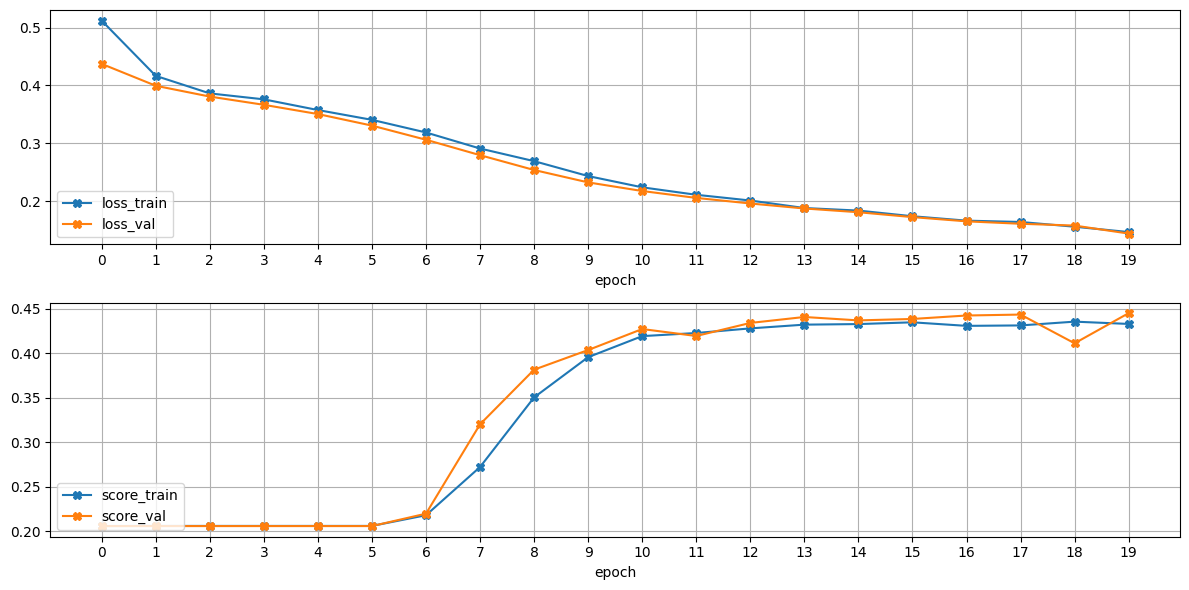

In [44]:
set_random_seed(42)

model = Network().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество на тестовой выборке.

In [45]:
# Your code here
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

              precision    recall  f1-score   support

       unacc       0.99      0.97      0.98       242
         acc       0.68      0.97      0.80        77
        good       0.00      0.00      0.00        14
       vgood       0.00      0.00      0.00        13

    accuracy                           0.89       346
   macro avg       0.42      0.49      0.45       346
weighted avg       0.85      0.89      0.86       346



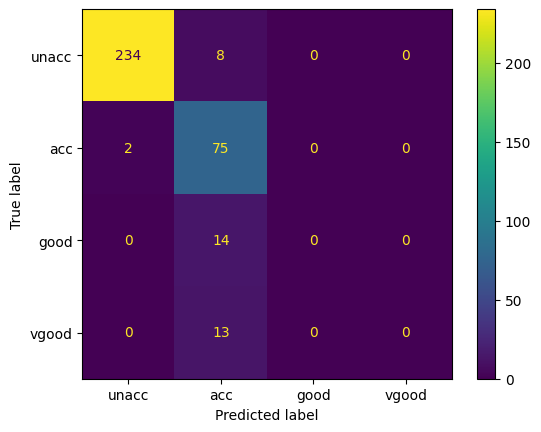

In [46]:
cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Опишите, как изменилось качество классификации.

Здесь картина по сути такая же как в бейзлайне. В данном случае применение focal loss без использования весов классов не особо помогает.

## Focal Loss с весами для классов

Обучите модель с Focal Loss, передав ей в качестве парамета `alpha` тензор весов `weights_for_classes`. Как и в прошлом пункте, используйте $\gamma=2$.

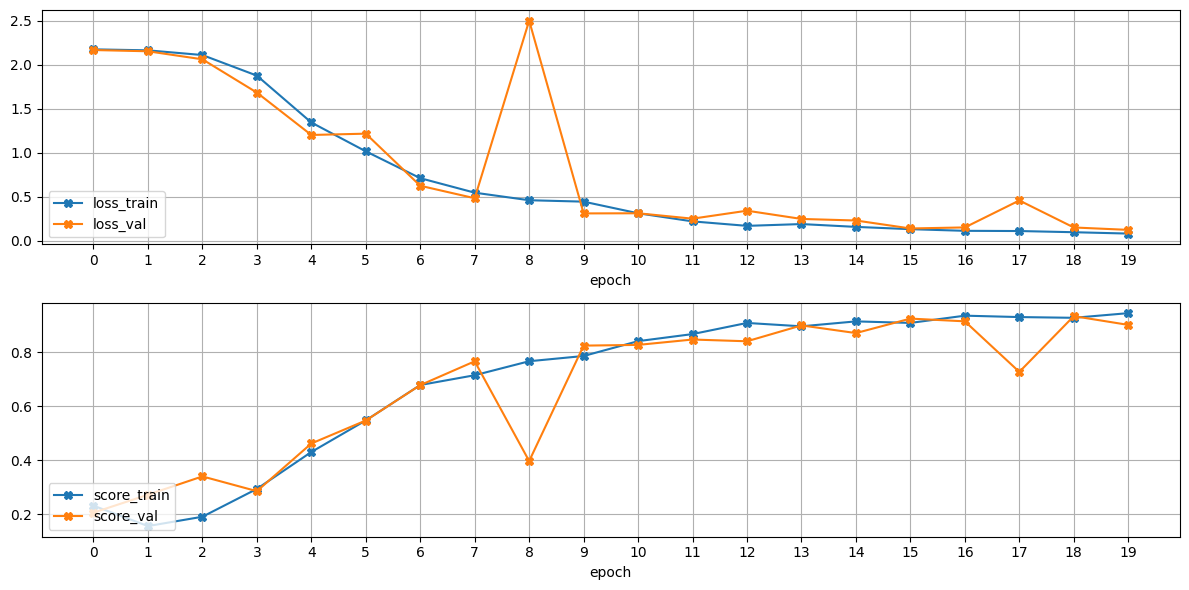

In [47]:
set_random_seed(42)

model = Network().to(device)

criterion =  FocalLoss(alpha=weights_for_classes, gamma=2.0)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество на тестовой выборке.

In [48]:
# Your code here
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

              precision    recall  f1-score   support

       unacc       1.00      0.94      0.97       242
         acc       0.83      0.95      0.88        77
        good       0.86      0.86      0.86        14
       vgood       0.81      1.00      0.90        13

    accuracy                           0.94       346
   macro avg       0.87      0.94      0.90       346
weighted avg       0.95      0.94      0.94       346



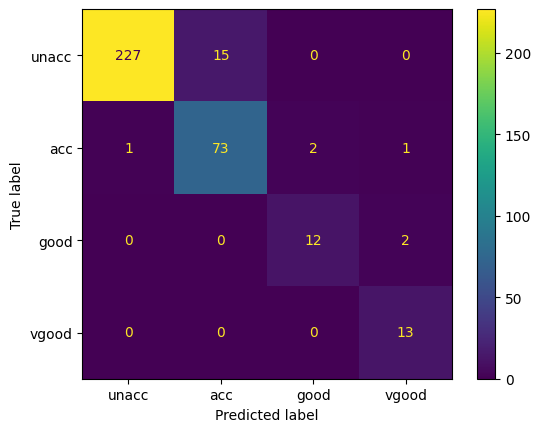

In [49]:
cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Опишите, как изменилось качество классификации.

Здесь видна сила focal loss с учетом весов классов! В данном случае пока мы наблюдаем самое большое значение f1 score = 0.9. Теперь и самый большой класс предсказывается гораздо лучше чем в случае с кросс-энтропией, и minor классы тоже предсказываются почти идеально.

## Weighted Random Sampler + Cross-Entropy Loss

Балансировать классы с помощью весов можно не только указывая их в функции потерь, но также и при формировании батчей.

Weighted Random Sampler занимается тем, что при формировании батчей учитывает веса разных объектов. Тем самым мы получаем возможность показывать модели объекты минорных классов чаще.

Особенность работы с Weighted Random Sampler в том, что ему нужно передать **веса для каждого объекта** в соответствии с тем, к какому классу этот объект относится. Создайте такой тензор весов `weight_for_every_sample`.

In [50]:
# Your code here
weight_for_every_sample = []

for label in y_train:
    weight_for_every_sample.append(weights_for_classes[label].item())


Теперь нужно создать `sampler`.

`WeightedRandomSampler`-у при инициализации нужно передать массив весов для каждого объекта, а также параметр `num_samples` — количество объектов для выдачи за одну эпоху. Этот параметр можно принять равным длине обучающей выборки.

Далее нужно заново создать обучающий `DataLoader`, и передать ему взвешенный `sampler`.

In [51]:
sampler = WeightedRandomSampler(torch.tensor(weight_for_every_sample), len(trainset))

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, sampler=sampler)

Обучите модель с Cross-Entropy Loss **без весов для классов**, используя созданный выше `DataLoader` со взвешенным сэмплером. Обратите внимание, что мы уже учли дисбаланс во взвешенном сэмплере, поэтому указывать веса в функции потерь не нужно.

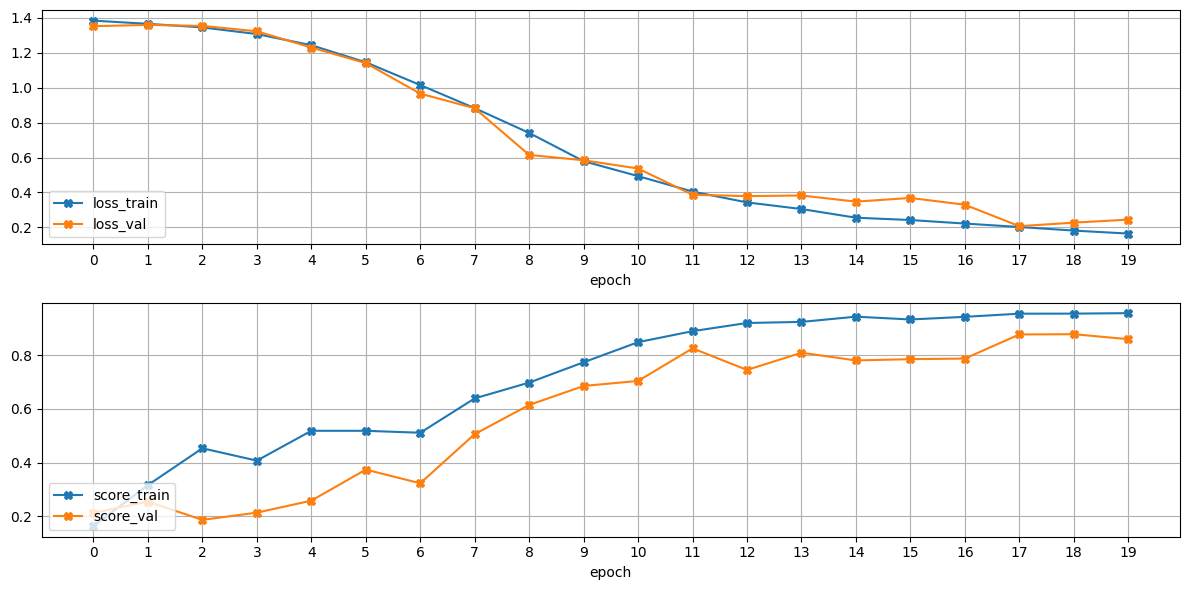

In [52]:
model = Network().to(device)

criterion =  nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество на тестовой выборке.

In [53]:
# Your code here
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

              precision    recall  f1-score   support

       unacc       1.00      0.88      0.94       242
         acc       0.72      0.95      0.82        77
        good       0.92      0.79      0.85        14
       vgood       0.72      1.00      0.84        13

    accuracy                           0.90       346
   macro avg       0.84      0.90      0.86       346
weighted avg       0.92      0.90      0.90       346



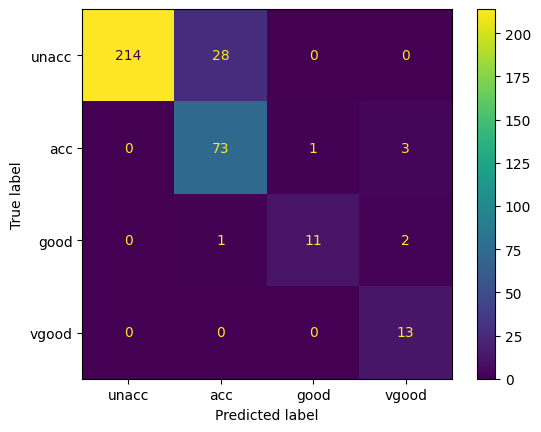

In [54]:
cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Опишите, как изменилось качество классификации.

По сравнению с предыдущим запуском качество чуть ухудшилось, до 0.85 (пока топ-2 результат).

## Weighted Random Sampler + Focal Loss

Повторите обучение с Focal Loss, используя уже созданный `DataLoader` со взвешенным сэмплером.

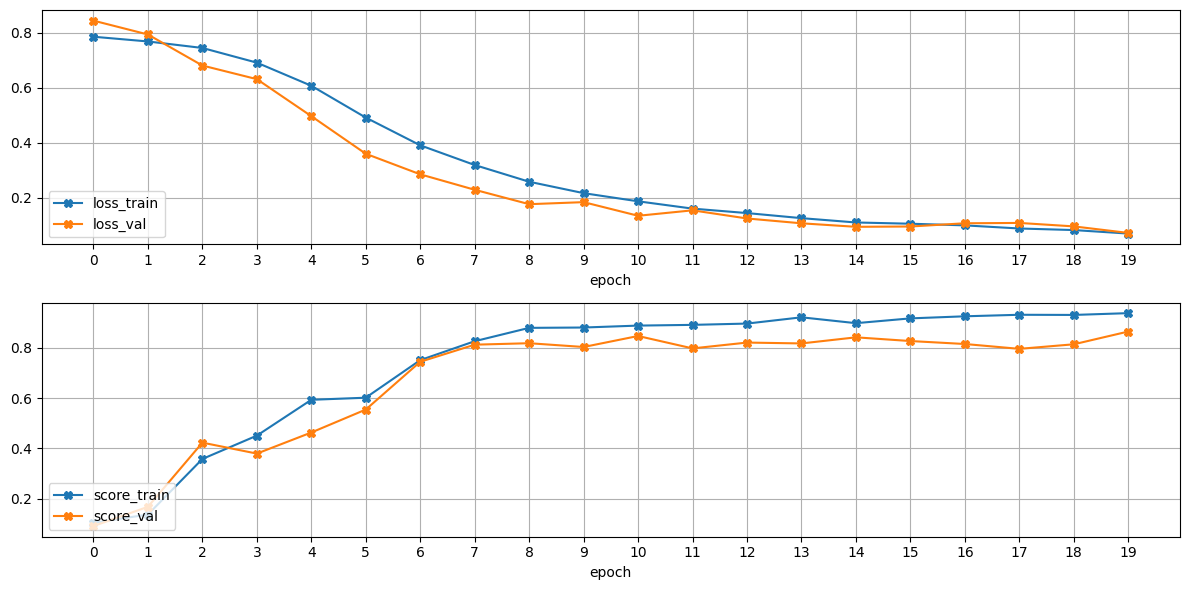

In [61]:
model = Network().to(device)

criterion = FocalLoss(gamma=2.0)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество на тестовой выборке.

In [62]:
# Your code here
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

              precision    recall  f1-score   support

       unacc       0.99      0.92      0.96       242
         acc       0.78      0.90      0.84        77
        good       0.80      0.86      0.83        14
       vgood       0.72      1.00      0.84        13

    accuracy                           0.92       346
   macro avg       0.82      0.92      0.86       346
weighted avg       0.93      0.92      0.92       346



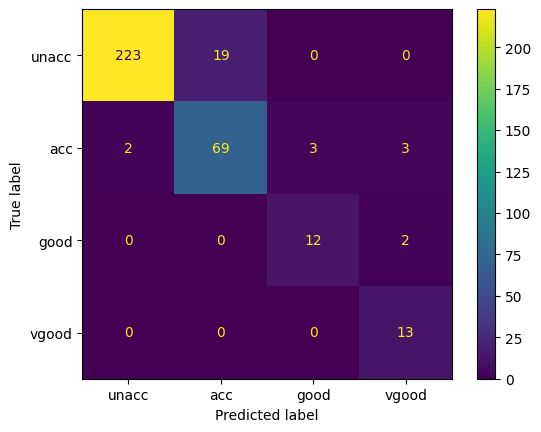

In [63]:
cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Опишите, как изменилось качество классификации.

f1 score в данном случае особо не изменился по сравнению с предыдущим случаем, но точность предсказания наибольшего класса выросла больше, чем упала точность предсказания второго класса.

## Сравнение результатов

Сравните результаты классификации тестовой выборки при обучении моделей с разными техниками борьбы с дисбалансом. В качестве меры сравнения можно выбрать *macro F-1 score*, который выводится в `classification_report`.

Ниже список попробованных функций потерь (и сэмплеров) по убыванию f1 score:

0. Focal Loss с весами для классов - 0.9
1. Weighted Random Sampler + Focal Loss - 0.86
2. Weighted Random Sampler + кросс-энтропия - 0.86
3. Кросс-энтропия с весами для классов - 0.75
4. Focal Loss - 0.45
5. Бейзлайн с кросс-энтропией - 0.45






## Формат результата

Результатом выполнения задания является обучение модели с шестью техниками:
0. Бейзлайн с кросс-энтропией
1. Кросс-энтропия с весами для классов
2. Focal Loss
3. Focal Loss с весами для классов
4. Weighted Random Sampler + кросс-энтропия
5. Weighted Random Sampler + Focal Loss

Для каждого обучения требуется вывести отчет о качестве классификации тестовой выборки и матрицу ошибок.
В конце требуется сравнить качество классификации по метрике *macro F-1 score*.